In [1]:
!pip install git+https://github.com/AlpacaDB/backlight

  Cloning https://github.com/keisuke-umezawa/backlight (to revision feature/plot-pl-AL-1737) to /tmp/pip-req-build-oy6vddin
Branch 'feature/plot-pl-AL-1737' set up to track remote branch 'feature/plot-pl-AL-1737' from 'origin'.
Switched to a new branch 'feature/plot-pl-AL-1737'
    100% |████████████████████████████████| 26.2MB 1.1MB/s 
    100% |████████████████████████████████| 13.9MB 2.4MB/s 
    100% |████████████████████████████████| 12.9MB 2.8MB/s 
    100% |████████████████████████████████| 133kB 30.8MB/s 
    100% |████████████████████████████████| 952kB 17.3MB/s 
    100% |████████████████████████████████| 61kB 23.3MB/s 
    100% |████████████████████████████████| 5.1MB 5.5MB/s 
    100% |████████████████████████████████| 552kB 22.4MB/s 
  Running setup.py bdist_wheel for backlight ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-gb55zgpa/wheels/a6/78/40/54a1fbaba272970e7b6036a64729fabecfa8df3fdde43f1ca9
Successfully built backlight
  Found existing installat

In [0]:
import os
import numpy as np
import pandas as pd
import backlight

# Generate example dummy data

In [0]:
np.random.seed(0)

# market data
if not os.path.exists("example_market.csv"):
    idx = pd.date_range("2018-04-01 00:00:00", "2018-06-30 23:59:59", freq="10S")
    ask = np.cumsum(np.random.rand(len(idx)) - 0.5) + 100.0
    bid = ask - 0.02
    pd.DataFrame(
        index=idx,
        data=np.array([ask, bid]).T,
        columns=["ask", "bid"]
    ).abs().to_csv("example_market.csv")

# signal data
if not os.path.exists("example_signal.csv"):
    sig = np.random.rand(3, len(idx)).T
    n = np.sum(sig, axis=1)
    pd.DataFrame(
        index=idx,
        data=sig / n.reshape(-1, 1),
        columns=["down", "neutral", "up"]
    ).to_csv("example_signal.csv")

# Configuration

In [0]:
model_id = ""
start_dt = "2018-06-03 00:00:00+0000"
end_dt = "2018-06-06 00:00:00+0000"
sig_url = "file:///{}/example_signal.csv".format(os.getcwd())
mkt_url = "file:///{}/example_market.csv".format(os.getcwd())

# loading the signal

In [0]:
from backlight import signal

SYMBOL = "USDJPY"
sig = signal.load_signal(SYMBOL, sig_url, start_dt, end_dt)

In [6]:
sig.tail()

,down,neutral,up,pred
2018-06-05 23:59:20,0.734946,0.104560,0.160494,-1.0
2018-06-05 23:59:30,0.360211,0.387104,0.252685,0.0
2018-06-05 23:59:40,0.234186,0.171650,0.594164,1.0
2018-06-05 23:59:50,0.351268,0.504142,0.144590,0.0
2018-06-06 00:00:00,0.292940,0.255769,0.451291,1.0


In [7]:
sig.symbol

'USDJPY'

# loading the marketdata

In [0]:
from backlight import datasource

mkt = datasource.load_marketdata(
    sig.symbol,
    sig.start_dt,
    sig.end_dt,
    mkt_url,
)

In [9]:
mkt.tail()

,ask,bid
2018-06-05 23:59:20,36.292220,36.272220
2018-06-05 23:59:30,36.633025,36.613025
2018-06-05 23:59:40,36.333093,36.313093
2018-06-05 23:59:50,36.066769,36.046769
2018-06-06 00:00:00,36.344929,36.324929


# generating labels

## Fixed Neutral

In [0]:
from backlight import labelizer
from backlight.labelizer.ternary.fixed_neutral import FixedNeutralLabelizer


lbl_fix = labelizer.generate_labels(
    mkt,
    FixedNeutralLabelizer(
        lookahead="3Min",
        neutral_atol=0.075,
        neutral_rtol=0.00,
    ))

In [11]:
lbl_fix.head()

,mid,label_diff,label
2018-06-03 00:00:00,80.257283,-0.854094,-1.0
2018-06-03 00:00:10,80.010294,-0.446213,-1.0
2018-06-03 00:00:20,79.701448,0.156435,1.0
2018-06-03 00:00:30,79.822766,-0.402531,-1.0
2018-06-03 00:00:40,79.959499,-0.609441,-1.0


In [12]:
lbl_fix.label_type

'ternary'

In [13]:
# (-1.0, 0.0, 1.0) : (Down, Neutral, Up)
lbl_fix.groupby("label").label.count() / len(lbl_fix)

label
-1.0    0.487906
 0.0    0.048262
 1.0    0.463138
Name: label, dtype: float64

## Dynamic Neutral

In [0]:
from backlight.labelizer.ternary.dynamic_neutral import DynamicNeutralLabelizer

lbl_dyn = labelizer.generate_labels(
    mkt,
    DynamicNeutralLabelizer(
        lookahead="3Min",
        neutral_ratio=0.38,
        neutral_window="1H",
        neutral_hard_limit=0.0,
    ))

In [15]:
lbl_dyn.head()

,label_diff,label,neutral_range
2018-06-03 00:00:00,-0.854094,-1.0,0.854094
2018-06-03 00:00:10,-0.446213,0.0,0.601208
2018-06-03 00:00:20,0.156435,0.0,0.376667
2018-06-03 00:00:30,-0.402531,0.0,0.408647
2018-06-03 00:00:40,-0.609441,-1.0,0.425246


In [16]:
lbl_dyn.label_type

'ternary'

In [17]:
# (-1.0, 0.0, 1.0) : (Down, Neutral, Up)
lbl_dyn.groupby("label").label.count() / len(lbl_dyn)

label
-1.0    0.317465
 0.0    0.382547
 1.0    0.299294
Name: label, dtype: float64

# simulate trading strategy

In [0]:
from backlight import strategies
trades = strategies.simple_entry_and_exit(mkt, sig, max_holding_time=pd.Timedelta('30min'))

# simulate and evaluate positions

In [0]:
from backlight import positions
positions = positions.calc_positions(trades, mkt)

In [20]:
positions.head()

,amount,price
2018-06-03 00:00:00,0.0,80.257283
2018-06-03 00:00:10,0.0,80.010294
2018-06-03 00:00:20,1.0,79.701448
2018-06-03 00:00:30,1.0,79.822766
2018-06-03 00:00:40,2.0,79.959499


# Calculate Metrics - based on the raw signals

In [21]:
from backlight import metrics
m = metrics.calc_metrics(sig, lbl_fix)
m

/usr/local/lib/python3.6/dist-packages/backlight/metrics/ternary.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pl.loc[sig.pred == TD.D.value] *= -1


,cnt_uu,cnt_un,cnt_ud,cnt_nu,cnt_nn,cnt_nd,cnt_du,cnt_dn,cnt_dd,cnt_total,hit_ratio,hedge_ratio,neutral_ratio,coverage,avg_pl,total_pl
metrics,3940.0,400.0,4238.0,4082.0,398.0,4178.0,3983.0,453.0,4231.0,25921.0,0.498475,0.523282,0.334015,0.665291,-0.003241,-55.89208


In [22]:
from backlight import metrics
m = metrics.calc_metrics(sig, lbl_dyn)
m

/usr/local/lib/python3.6/dist-packages/backlight/metrics/ternary.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pl.loc[sig.pred == TD.D.value] *= -1


,cnt_uu,cnt_un,cnt_ud,cnt_nu,cnt_nn,cnt_nd,cnt_du,cnt_dn,cnt_dd,cnt_total,hit_ratio,hedge_ratio,neutral_ratio,coverage,avg_pl,total_pl
metrics,2528.0,3302.0,2748.0,2663.0,3262.0,2733.0,2567.0,3352.0,2748.0,25921.0,0.498159,0.691795,0.334015,0.665291,-0.003241,-55.89208


# Calculate Performance

In [23]:
from backlight import metrics
m = metrics.calc_position_performance(positions)
m

,avg_pl_per_amount,total_pl,total_win_pl,total_lose_pl,cnt_amount
metrics,-0.021391,-491.601016,27839.818609,-28331.419624,22982.0


In [24]:
from backlight import metrics
m = metrics.calc_trade_performance(trades, mkt)
m

,cnt_trade,cnt_win,cnt_lose,win_ratio,lose_ratio,avg_pl_per_amount,total_pl,total_win_pl,total_lose_pl,cnt_amount,avg_win_pl,avg_lose_pl,avg_pl_per_trade
metrics,25921.0,8608.0,8646.0,0.332086,0.333552,-0.021391,-491.601016,27839.818609,-28331.419624,22982.0,3.23418,-3.276824,-0.018965


# Plot positions

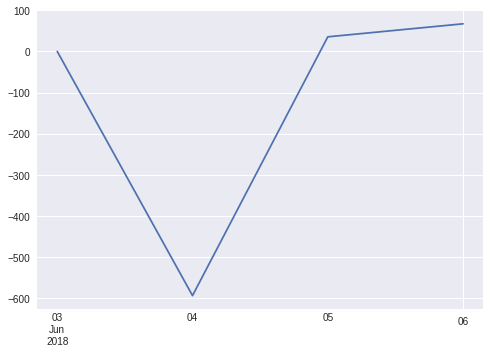

In [25]:
from backlight import plot

plot.plot_pl(positions)

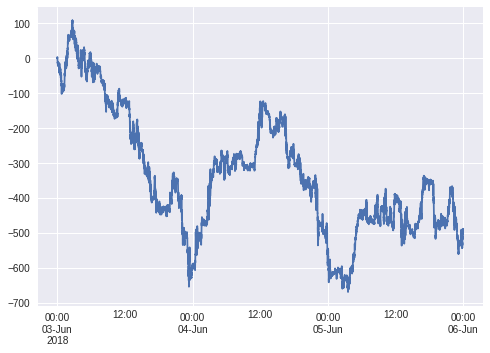

In [27]:
from backlight import plot

plot.plot_cumulative_pl(positions)